In [1]:
%config Completer.use_jedi = False

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Dict, Tuple
from evaluation_utils.evaluation_utils import map_dict_values

In [3]:
import sys
sys.path.append('..')

In [4]:
print(sys.path)

['/home/flo/Workspace/Uni/Masterarbeit/simulation/visualization', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/flo/Workspace/Uni/Masterarbeit/mosaikvenv/lib/python3.8/site-packages', '/home/flo/Workspace/Uni/Masterarbeit/simulation', '/home/flo/Workspace/Uni/Masterarbeit/simulation/batterysim', '/home/flo/Workspace/Uni/Masterarbeit/simulation/householdsim', '/home/flo/Workspace/Uni/Masterarbeit/mosaikvenv/lib/python3.8/site-packages/IPython/extensions', '/home/flo/.ipython', '..']


In [5]:
import evaluation_utils.hdf5_to_df
from evaluation_utils.pricing import *

In [6]:
from pathlib import PurePath


simulation_directory = PurePath("data/enerdag_sim_prosumer/householdsim")

sim_name = "from_2016-03-01_to_2017-02-01_ConProPV_(3, 3, 0)_%s.hdf5"
def create_sim_file_name(specifier):
    return PurePath(simulation_directory, sim_name % specifier)
#import os 
#os.listdir(simulation_directory)

In [7]:
figure_folder = PurePath("figures/cossmic")

# Wirtschaftlichkeit Vergleichen
## Arten des Stromhandels
Vergleiche Stromkosten der Prosumenten und Konsumenten
- Kein PV
- PV ohne enerDAG
- PV + Batterie ohne enerDAG
- enerDAG ohne Batterie
- enerDAG mit SimpleBattery
- enerDAG mit SmartBattery (SARIMA Modell)


In [8]:
prices = PriceSpec(
            Money(int(714 * Money.FRACTION_MULTIPLIER / 100) ),
            Money(int(31 * Money.FRACTION_MULTIPLIER)),
            cost_of_generation=Money(6 * Money.FRACTION_MULTIPLIER ),
            cost_of_storage=Money((int) (55 * Money.FRACTION_MULTIPLIER / 10)),
            enerdag_net_costs=Money.from_cents(5),
            avg_p2p_trade=Money.from_cents(19),)


KEY_NO_BATTERY = "No Battery"
KEY_SIMPLE_10_kWh = "Simple Battery (10 kWh)"
KEY_SIMPLE_5_kWh = "Simple Battery (5 kWh)"
KEY_SARIMA_SMART_10kWh  = "SARIMA Smart Battery (10 kWh)"
KEY_PERFECT_SMART_10kWh = "Perfect SmartBattery (10 kWh)"
KEY_SARIMA_SMART_5kWh = "SARIMA SmartBattery (5 kWh)"
KEY_PERFECT_SMART_5kWh = "Perfect SmartBattery (5 kWh)"

simulation_file_paths =  {
    KEY_NO_BATTERY: create_sim_file_name("NoBattery_0Wh"),
    KEY_SIMPLE_10_kWh: create_sim_file_name("SimpleBattery_10000Wh"),
    KEY_SARIMA_SMART_10kWh: create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_10000Wh"),
    KEY_SIMPLE_5_kWh: create_sim_file_name("SimpleBattery_5000Wh"),
    KEY_SARIMA_SMART_5kWh: create_sim_file_name("CSV_(1, 0, 1)_(2, 0, 0, 24)_history_4_SmartBattery_5000Wh")
}


def create_new_dict_with_function(d, func):
    new_d = dict()
    for sim in d:
        new_d[sim] = func(d[sim])
    return new_d



  


simulation_dataframes = map_dict_values(simulation_file_paths, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))

simulation_costs = map_dict_values(simulation_dataframes, lambda x: dict([(name, household_power_cost(df, prices)) for (name, df) in x.items()]))



In [9]:
def eid_to_label(eid: str) -> str:
    if "pid" in eid:
        pid = int(eid.split("pid")[1][0])
        return "Prosumer %d" % (pid, )
    else: 
        return eid.split(".")[-1]
def print_model_costs(prices: Dict[str, List[Tuple[str, float]]]):
    for model, model_prices in prices.items():
        print("%s: %.2f" % (model, sum(map(lambda x: x[1], model_prices))))
        for pid, price in model_prices:
            print("\t%s: %.2f" % (eid_to_label(pid), price))
    
def tex_model_costs(prices: Dict[str, List[Tuple[str, float]]]):
    s = ""
    for model, model_prices in prices.items():
        s =  "%s%s" % (s, model ,)
        total =  sum(map(lambda x: x[1], model_prices))
        for pid, price in model_prices:
            s = ("%s & \\myEUR{%.2f}" % (s, price)).replace(".", ",")
        s = ("%s & \\myEUR{%.2f}" % (s, total)).replace(".", ",")
        s = ("%s  \\\\ %s" % (s, os.linesep))
    
    return s


In [10]:
def construct_cost_info_string(d):
    s = ""
    for sim in d:
        s += sim + os.linesep
        for eid, stats in d[sim].items():
            s += eid_to_label(eid) + os.linesep
            s += str(stats) + os.linesep
    return s
print(construct_cost_info_string(simulation_costs))

No Battery
consumer_0
	total: 723.68€ = 2558.05kWH * 0.28€ 
	buy_p2p: 198.22€ = 825.92kWH * 0.24€ 
	sell_to_p2p: 0.00€ = 0.00kWH * 0.00€ 
	buy_from_utilities: 525.46€ = 1695.04kWH * 0.31€ 
	sell_to_utlitites: 0.00€ = 0.00kWH * 0.00€ 
	cost_of_generation: 0.00€ = 0.00kWH * 0.00€ 
	cost_of_discharge: 0.00€ = 0.00kWH * 0.00€ 
consumer_1
	total: 682.09€ = 2381.09kWH * 0.28€ 
	buy_p2p: 149.37€ = 622.40kWH * 0.24€ 
	sell_to_p2p: 0.00€ = 0.00kWH * 0.00€ 
	buy_from_utilities: 532.72€ = 1718.45kWH * 0.31€ 
	sell_to_utlitites: 0.00€ = 0.00kWH * 0.00€ 
	cost_of_generation: 0.00€ = 0.00kWH * 0.00€ 
	cost_of_discharge: 0.00€ = 0.00kWH * 0.00€ 
consumer_2
	total: 1330.61€ = 4661.95kWH * 0.28€ 
	buy_p2p: 346.26€ = 1442.76kWH * 0.24€ 
	sell_to_p2p: 0.00€ = 0.00kWH * 0.00€ 
	buy_from_utilities: 984.34€ = 3175.32kWH * 0.31€ 
	sell_to_utlitites: 0.00€ = 0.00kWH * 0.00€ 
	cost_of_generation: 0.00€ = 0.00kWH * 0.00€ 
	cost_of_discharge: 0.00€ = 0.00kWH * 0.00€ 
Prosumer 1
	total: 768.68€ = 4661.96kWH * 0.1

In [11]:
def calc_buy_cost(energy_stats: HouseholdEnergyStats, price_spec: PriceSpec):
    """ 
    Calculate the Cost when someone buys all the consumed energy from the utility provider
    """
    return (energy_stats.total_energy.total_energy * price_spec.cost_buy_from_grid.to_euro()) / 1000

def filter_prosumers_and_apply_func(func, energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))
    return [(name, func(stats, prices)) for (name,stats) in prosumers.items()]

def cal_buy_cost_for_prosumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_prosumers_and_apply_func(calc_buy_cost, energy_stats, prices)

def calc_pv_wo_enerdag(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))    
    return [(name, calc_costs_pv_wo_enerdag(stats, prices).to_euro()) for (name, stats) in prosumers.items()]


def calc_pv_and_batter_wo_enerdag(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))    
    return [(name, calc_costs_pv_and_battery_wo_enerdag(stats, prices).to_euro()) for (name,stats) in prosumers.items()]

def calc_enerdag_total_cost(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "prosumer" in x[0], list(energy_stats.items()))))    
    return [(name, household_power_cost(stats, prices).total_energy.total_money.to_euro()) for (name,stats) in prosumers.items()]


NO_PV = "No PV"
PV_AND_BATT_10kWh = "PV + Battery (10kWh) w/o enerDAG"
PV_AND_BATT_5kWh = "PV + Battery (5kWh) w/o enerDAG"
PV_WO_ENERDAG = "PV w/o enerDAG"
ENERDAG_WO_BATT = "enerDAG w/o battery"
ENERDAG_WITH_10kWh_SIMPLE = "enerDAG Simple Battery (10 kWh)"
ENERDAG_WITH_5kWh_SIMPLE = "enerDAG Simple Battery (5 kWh)"
ENERDAG_WITH_10kWh_SMART = "enerDAG Smart Battery (10 kWh)"
ENERDAG_WITH_5kWh_SMART = "enerDAG Smart Battery (5 kWh)"


plot_data_prosumers = {
    # NO_PV:  cal_buy_cost_for_prosumers(simulation_costs[KEY_NO_BATTERY], prices), 
    PV_WO_ENERDAG: calc_pv_wo_enerdag(simulation_dataframes[KEY_NO_BATTERY], prices), 
    ENERDAG_WO_BATT: calc_enerdag_total_cost(simulation_dataframes[KEY_NO_BATTERY], prices),
    PV_AND_BATT_10kWh: calc_pv_and_batter_wo_enerdag(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WITH_10kWh_SIMPLE: calc_enerdag_total_cost(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WITH_10kWh_SMART: calc_enerdag_total_cost(simulation_dataframes[KEY_SARIMA_SMART_10kWh], prices), 
    PV_AND_BATT_5kWh: calc_pv_and_batter_wo_enerdag(simulation_dataframes[KEY_SIMPLE_5_kWh], prices), 
    ENERDAG_WITH_5kWh_SIMPLE: calc_enerdag_total_cost(simulation_dataframes[KEY_SIMPLE_5_kWh], prices), 
    ENERDAG_WITH_5kWh_SMART: calc_enerdag_total_cost(simulation_dataframes[KEY_SARIMA_SMART_5kWh], prices), 
}


In [12]:
print_model_costs(plot_data_prosumers)

PV w/o enerDAG: 3234.20
	Prosumer 1: 905.63
	Prosumer 3: 1137.21
	Prosumer 4: 1191.36
enerDAG w/o battery: 2824.75
	Prosumer 1: 768.68
	Prosumer 3: 1029.22
	Prosumer 4: 1026.85
PV + Battery (10kWh) w/o enerDAG: 2353.27
	Prosumer 1: 562.07
	Prosumer 3: 847.89
	Prosumer 4: 943.31
enerDAG Simple Battery (10 kWh): 2122.91
	Prosumer 1: 483.63
	Prosumer 3: 819.19
	Prosumer 4: 820.09
enerDAG Smart Battery (10 kWh): 2011.97
	Prosumer 1: 434.38
	Prosumer 3: 807.17
	Prosumer 4: 770.42
PV + Battery (5kWh) w/o enerDAG: 2568.00
	Prosumer 1: 648.04
	Prosumer 3: 924.63
	Prosumer 4: 995.33
enerDAG Simple Battery (5 kWh): 2318.37
	Prosumer 1: 561.43
	Prosumer 3: 884.34
	Prosumer 4: 872.60
enerDAG Smart Battery (5 kWh): 2293.97
	Prosumer 1: 548.51
	Prosumer 3: 884.98
	Prosumer 4: 860.48


In [13]:



def create_stacked_barchart(ax, plot_data, colors):
    bar_x_coordinates = []
    bar_height = []
    bar_y_coordinates = []
    bar_color = []
    tick_labels = []
    legend = None
    for x_index, (configuration, costs) in enumerate(plot_data.items()):

        legend = []
        for y_index, cost in enumerate(costs):
          


            legend.append(eid_to_label(cost[0]))
            tick_labels.append(configuration)

            bar_x_coordinates.append(x_index)
            y_coord = sum(list(map(lambda x: x[1], costs[:y_index])))
            bar_y_coordinates.append(y_coord)
            bar_height.append(cost[1])
            bar_color.append(colors[y_index])
        
    ax.bar(x=bar_x_coordinates[::3], height=bar_height[::3], tick_label=tick_labels[::3] ,bottom=bar_y_coordinates[::3], color=bar_color[::3])
    ax.bar(x=bar_x_coordinates[1::3], height=bar_height[1::3], tick_label=tick_labels[1::3] ,bottom=bar_y_coordinates[1::3], color=bar_color[1::3])
    ax.bar(x=bar_x_coordinates[2::3], height=bar_height[2::3], tick_label=tick_labels[2::3] ,bottom=bar_y_coordinates[2::3], color=bar_color[2::3])
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_ylabel("€")
    return legend

def print_costs(plot_data): 
     for (configuration, costs) in plot_data.items():

        
        print(configuration)
        total = 0
        for cost in costs:
            household_name = eid_to_label(cost[0])
            cost_household = cost[1]
            print("\t%s: %.2f" % (household_name, cost_household))
        total  = sum(list(map(lambda x: x[1], costs)))
        print("\ttotal: %.2f" % ( total, ))

def get_min_max_costs(plot_data): 
    min_costs = np.float64("inf")
    max_costs = np.float64("-inf")

    max_config, max_households  = (None, None)
    min_config, min_households  = (None, None)
    for  (configuration, costs) in plot_data.items():

        total  = sum(list(map(lambda x: x[1], costs)))
        if total > max_costs:
            max_costs = total
            max_config = configuration
            max_households = costs
        if total < min_costs:
            min_costs = total
            min_config = configuration
            min_households = costs
        
    print("Max: %s: %.2f" % (max_config, max_costs) )
    print("\t", max_households)
    
    print("Min: %s: %.2f" % (min_config, min_costs) )
    print("\t", min_households)
    
            


Max: PV w/o enerDAG: 3234.20
	 [('Series/Rust_Sim-0.pid1_prosumer_0', 905.63), ('Series/Rust_Sim-0.pid3_prosumer_1', 1137.21), ('Series/Rust_Sim-0.pid4_prosumer_2', 1191.36)]
Min: enerDAG Smart Battery (10 kWh): 2011.97
	 [('Series/Rust_Sim-0.pid1_prosumer_0', 434.38), ('Series/Rust_Sim-0.pid3_prosumer_1', 807.17), ('Series/Rust_Sim-0.pid4_prosumer_2', 770.42)]


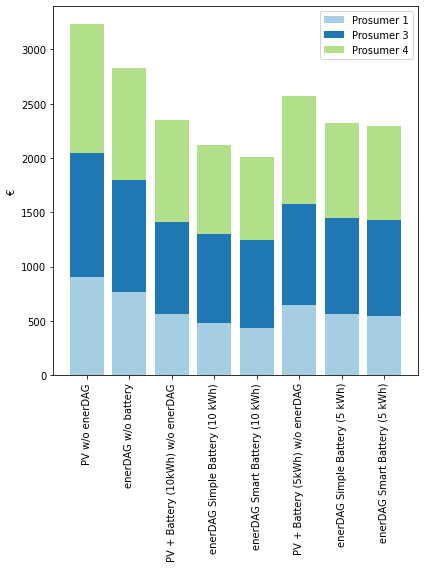

In [14]:
fig, ax = plt.subplots(figsize=(6,8))

# https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=4
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']

market_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']


legend = create_stacked_barchart(ax, plot_data_prosumers, colors=colors)
ax.legend(legend)
# print_costs(plot_data_prosumers)
get_min_max_costs(plot_data_prosumers)
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparison_neighborhood_configs.png"))


In [15]:
print(tex_model_costs(plot_data_prosumers))

PV w/o enerDAG & \myEUR{905,63} & \myEUR{1137,21} & \myEUR{1191,36} & \myEUR{3234,20}  \\ 
enerDAG w/o battery & \myEUR{768,68} & \myEUR{1029,22} & \myEUR{1026,85} & \myEUR{2824,75}  \\ 
PV + Battery (10kWh) w/o enerDAG & \myEUR{562,07} & \myEUR{847,89} & \myEUR{943,31} & \myEUR{2353,27}  \\ 
enerDAG Simple Battery (10 kWh) & \myEUR{483,63} & \myEUR{819,19} & \myEUR{820,09} & \myEUR{2122,91}  \\ 
enerDAG Smart Battery (10 kWh) & \myEUR{434,38} & \myEUR{807,17} & \myEUR{770,42} & \myEUR{2011,97}  \\ 
PV + Battery (5kWh) w/o enerDAG & \myEUR{648,04} & \myEUR{924,63} & \myEUR{995,33} & \myEUR{2568,00}  \\ 
enerDAG Simple Battery (5 kWh) & \myEUR{561,43} & \myEUR{884,34} & \myEUR{872,60} & \myEUR{2318,37}  \\ 
enerDAG Smart Battery (5 kWh) & \myEUR{548,51} & \myEUR{884,98} & \myEUR{860,48} & \myEUR{2293,97}  \\ 



## Vergleiche die Vorhersagemodelle bei enerDAG mit SmartBattery 
Stromkosten von SmartBattery bei verschiedenen Vorhersagemodellen
- SARIMA
- UEMA
- B24
- Perfect
    

In [16]:
def sarima_model_str(ar, i, ma, p, q, d) -> str:
    return "CSV_(%d, %d, %d)_(%d, %d, %d, 24)_history_4_SmartBattery_10000Wh" %(ar, i, ma, p, q,d)

MODEL_PERFECT = "Perfect"
MODEL_B24 = "B24"
MODEL_SARIMA_101 = "$(1,0,1)\\times (1,0,1)24$"
MODEL_SARIMA_200 = "$(1,0,1)\\times (2,0,0)24$"

simulation_files_model_comparison =  {
    MODEL_PERFECT: create_sim_file_name('CSV_perfect_SmartBattery_10000Wh'), 
    MODEL_B24: create_sim_file_name('CSV_backschift_24h_SmartBattery_10000Wh'),
    MODEL_SARIMA_101: create_sim_file_name(sarima_model_str(1,0,1,1,0,1)),
    MODEL_SARIMA_200: create_sim_file_name(sarima_model_str(1,0,1,2,0,0)), 
}


simulation_dataframes_model_comparison = map_dict_values(simulation_files_model_comparison, lambda x: convert_hdf5_to_viewdict(h5py.File(x)))

sim_hh_costs_model_comparison = map_dict_values(simulation_dataframes_model_comparison, lambda x: dict([(name, household_power_cost(df, prices)) for (name, df) in x.items()]))

plot_data_model_comparison = dict()
for sim in simulation_dataframes_model_comparison:
    plot_data_model_comparison[sim] = calc_enerdag_total_cost(simulation_dataframes_model_comparison[sim], prices)


Max: B24: 2013.82
	 [('Series/Rust_Sim-0.pid1_prosumer_0', 437.28), ('Series/Rust_Sim-0.pid3_prosumer_1', 809.55), ('Series/Rust_Sim-0.pid4_prosumer_2', 766.99)]
Min: Perfect: 1973.90
	 [('Series/Rust_Sim-0.pid1_prosumer_0', 420.19), ('Series/Rust_Sim-0.pid3_prosumer_1', 801.44), ('Series/Rust_Sim-0.pid4_prosumer_2', 752.27)]


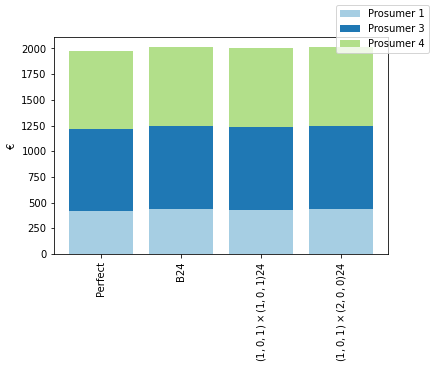

In [17]:
fig, ax = plt.subplots()
legend = create_stacked_barchart(ax, plot_data_model_comparison, colors=colors)
# print_costs(plot_data_model_comparison)
get_min_max_costs(plot_data_model_comparison)

fig.legend(legend);
fig.savefig(PurePath(figure_folder, "economic_comparisons_models.png"))


In [18]:

print_model_costs(plot_data_model_comparison)

Perfect: 1973.90
	Prosumer 1: 420.19
	Prosumer 3: 801.44
	Prosumer 4: 752.27
B24: 2013.82
	Prosumer 1: 437.28
	Prosumer 3: 809.55
	Prosumer 4: 766.99
$(1,0,1)\times (1,0,1)24$: 2008.81
	Prosumer 1: 433.00
	Prosumer 3: 806.90
	Prosumer 4: 768.91
$(1,0,1)\times (2,0,0)24$: 2011.97
	Prosumer 1: 434.38
	Prosumer 3: 807.17
	Prosumer 4: 770.42


In [19]:
# Ausgabe ist zum erstellen einer tex tabelle da.
print(tex_model_costs(plot_data_model_comparison))

Perfect & \myEUR{420,19} & \myEUR{801,44} & \myEUR{752,27} & \myEUR{1973,90}  \\ 
B24 & \myEUR{437,28} & \myEUR{809,55} & \myEUR{766,99} & \myEUR{2013,82}  \\ 
$(1,0,1)\times (1,0,1)24$ & \myEUR{433,00} & \myEUR{806,90} & \myEUR{768,91} & \myEUR{2008,81}  \\ 
$(1,0,1)\times (2,0,0)24$ & \myEUR{434,38} & \myEUR{807,17} & \myEUR{770,42} & \myEUR{2011,97}  \\ 



In [20]:
# print(construct_cost_info_string(sim_hh_costs_model_comparison))

In [21]:
def create_diff_data(data: Dict[str, List[Tuple[str, float]]], base_key) -> Dict[str, List[Tuple[str, float]]]:
    base = data[base_key]
    new_data = dict()
    for key in data:
        if key == base_key:
            continue
        model_result = [(base_key if base_key == model_key else "keys dont match", model_val - base_val) 
                            for (base_key, base_val), (model_key, model_val) in zip(base, data[key])]
        

        new_data[key] = model_result
    return new_data

model_comparison_diff = create_diff_data(plot_data_model_comparison, MODEL_PERFECT)


Max: B24: 39.92
	 [('Series/Rust_Sim-0.pid1_prosumer_0', 17.089999999999975), ('Series/Rust_Sim-0.pid3_prosumer_1', 8.1099999999999), ('Series/Rust_Sim-0.pid4_prosumer_2', 14.720000000000027)]
Min: $(1,0,1)\times (1,0,1)24$: 34.91
	 [('Series/Rust_Sim-0.pid1_prosumer_0', 12.810000000000002), ('Series/Rust_Sim-0.pid3_prosumer_1', 5.459999999999923), ('Series/Rust_Sim-0.pid4_prosumer_2', 16.639999999999986)]


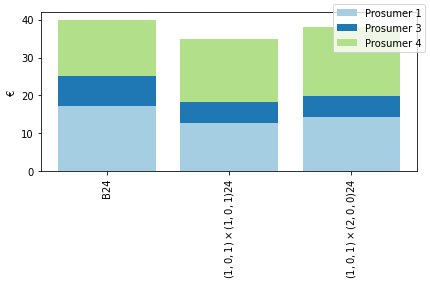

In [22]:

fig, ax = plt.subplots()
legend = create_stacked_barchart(ax, model_comparison_diff, colors=colors)
# print_costs(plot_data_model_comparison)
get_min_max_costs(model_comparison_diff)

fig.legend(legend);
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparisons_models_difference.png"))

In [23]:
scenario_diff_plot_data = plot_data_model_comparison
scenario_diff_plot_data[ENERDAG_WITH_10kWh_SIMPLE] = plot_data_prosumers[ENERDAG_WITH_10kWh_SIMPLE]
scenario_comp_diff = create_diff_data(scenario_diff_plot_data, ENERDAG_WITH_10kWh_SIMPLE)


In [24]:
print_model_costs(scenario_diff_plot_data)


Perfect: 1973.90
	Prosumer 1: 420.19
	Prosumer 3: 801.44
	Prosumer 4: 752.27
B24: 2013.82
	Prosumer 1: 437.28
	Prosumer 3: 809.55
	Prosumer 4: 766.99
$(1,0,1)\times (1,0,1)24$: 2008.81
	Prosumer 1: 433.00
	Prosumer 3: 806.90
	Prosumer 4: 768.91
$(1,0,1)\times (2,0,0)24$: 2011.97
	Prosumer 1: 434.38
	Prosumer 3: 807.17
	Prosumer 4: 770.42
enerDAG Simple Battery (10 kWh): 2122.91
	Prosumer 1: 483.63
	Prosumer 3: 819.19
	Prosumer 4: 820.09


Max: B24: -109.09
	 [('Series/Rust_Sim-0.pid1_prosumer_0', -46.35000000000002), ('Series/Rust_Sim-0.pid3_prosumer_1', -9.6400000000001), ('Series/Rust_Sim-0.pid4_prosumer_2', -53.10000000000002)]
Min: Perfect: -149.01
	 [('Series/Rust_Sim-0.pid1_prosumer_0', -63.44), ('Series/Rust_Sim-0.pid3_prosumer_1', -17.75), ('Series/Rust_Sim-0.pid4_prosumer_2', -67.82000000000005)]


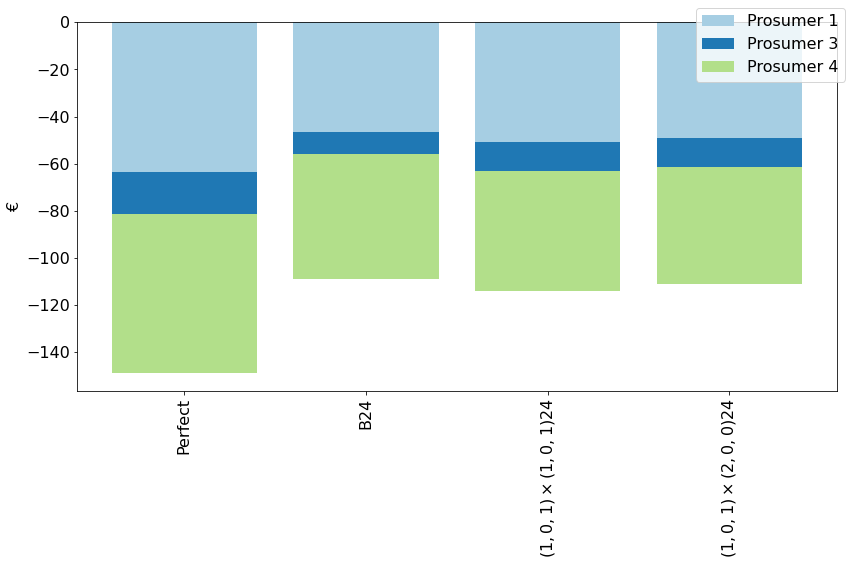

In [25]:

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(12,8))
legend = create_stacked_barchart(ax, scenario_comp_diff, colors=colors)
# print_costs(plot_data_model_comparison)
get_min_max_costs(scenario_comp_diff)

fig.legend(legend);
fig.tight_layout()
fig.savefig(PurePath(figure_folder, "economic_comparisons_smart_simple_battery.png"))


In [26]:
fig.get_size_inches() * 1.5

array([18., 12.])

# Für Konsumenten: 


In [27]:
def consumer_calc_buy_cost(energy_stats: HouseholdEnergyStats, price_spec: PriceSpec):
    """ 
    Calculate the Cost when someone buys all the consumed energy from the utility provider
    """
    return (energy_stats.total_energy.total_energy * price_spec.cost_buy_from_grid.to_euro()) / 1000

def filter_consumers_and_apply_func(func, energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    prosumers = dict(list(filter(lambda x: "consumer" in x[0], list(energy_stats.items()))))
    return [(name, func(stats, prices)) for (name,stats) in prosumers.items()]

def cal_buy_cost_for_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda x,y : consumer_calc_buy_cost(x,y), energy_stats, prices)

def calc_pv_wo_enerdag_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda x,y: calc_costs_pv_wo_enerdag(x,y).to_euro(), energy_stats, prices)
    


def calc_pv_and_batter_wo_enerdag_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda x,y: calc_costs_pv_and_battery_wo_enerdag(x,y).to_euro(), energy_stats, prices)
    
def calc_enerdag_total_cost_consumers(energy_stats: Dict[str, HouseholdEnergyStats], prices: PriceSpec):
    return filter_consumers_and_apply_func(lambda stats, prices: household_power_cost(stats, prices).total_energy.total_money.to_euro(), energy_stats, prices)


In [28]:
simulation_dataframes.keys()

dict_keys(['No Battery', 'Simple Battery (10 kWh)', 'SARIMA Smart Battery (10 kWh)', 'Simple Battery (5 kWh)', 'SARIMA SmartBattery (5 kWh)'])

In [29]:

plot_data_consumers = {
     # "Kein PV":  cal_buy_cost_for_consumers(simulation_costs["NoBattery"], prices), 
    #"Ohne enerDAG": calc_pv_wo_enerdag_consumers(simulation_dataframes["NoBattery"], prices), 
    PV_AND_BATT_10kWh: calc_pv_and_batter_wo_enerdag_consumers(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WO_BATT: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_NO_BATTERY], prices),
    ENERDAG_WITH_10kWh_SIMPLE: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SIMPLE_10_kWh], prices), 
    ENERDAG_WITH_10kWh_SMART: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SARIMA_SMART_10kWh], prices), 
}
    

Max: PV + Battery (10kWh) w/o enerDAG: 2938.75
	 [('Series/Rust_Sim-0.consumer_0', 781.49), ('Series/Rust_Sim-0.consumer_1', 725.66), ('Series/Rust_Sim-0.consumer_2', 1431.6)]
Min: enerDAG Smart Battery (10 kWh): 2657.83
	 [('Series/Rust_Sim-0.consumer_0', 662.38), ('Series/Rust_Sim-0.consumer_1', 1286.59), ('Series/Rust_Sim-0.consumer_2', 708.86)]


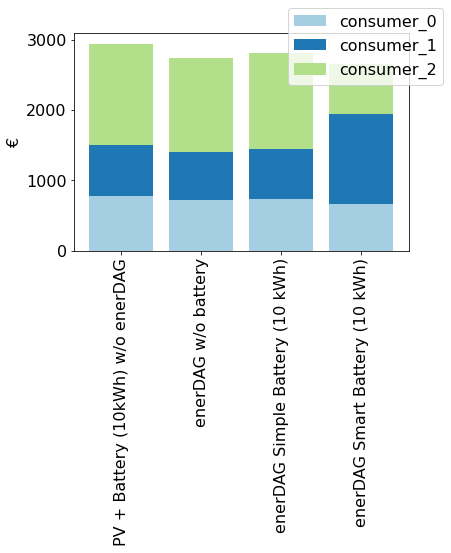

In [30]:
fig, ax = plt.subplots()
legend = create_stacked_barchart(ax, plot_data_consumers, colors=colors)
get_min_max_costs(plot_data_consumers)

fig.legend(legend);

In [31]:
print(tex_model_costs(plot_data_consumers))

PV + Battery (10kWh) w/o enerDAG & \myEUR{781,49} & \myEUR{725,66} & \myEUR{1431,60} & \myEUR{2938,75}  \\ 
enerDAG w/o battery & \myEUR{723,68} & \myEUR{682,09} & \myEUR{1330,61} & \myEUR{2736,38}  \\ 
enerDAG Simple Battery (10 kWh) & \myEUR{743,59} & \myEUR{697,83} & \myEUR{1362,08} & \myEUR{2803,50}  \\ 
enerDAG Smart Battery (10 kWh) & \myEUR{662,38} & \myEUR{1286,59} & \myEUR{708,86} & \myEUR{2657,83}  \\ 



In [32]:
plot_data_consumers
print_model_costs(plot_data_consumers)

PV + Battery (10kWh) w/o enerDAG: 2938.75
	consumer_0: 781.49
	consumer_1: 725.66
	consumer_2: 1431.60
enerDAG w/o battery: 2736.38
	consumer_0: 723.68
	consumer_1: 682.09
	consumer_2: 1330.61
enerDAG Simple Battery (10 kWh): 2803.50
	consumer_0: 743.59
	consumer_1: 697.83
	consumer_2: 1362.08
enerDAG Smart Battery (10 kWh): 2657.83
	consumer_0: 662.38
	consumer_1: 1286.59
	consumer_2: 708.86


In [37]:
plot_data_consumers_5kWh = {
     # "Kein PV":  cal_buy_cost_for_consumers(simulation_costs["NoBattery"], prices), 
    #"Ohne enerDAG": calc_pv_wo_enerdag_consumers(simulation_dataframes["NoBattery"], prices), 
    
    
    ENERDAG_WITH_5kWh_SIMPLE: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SIMPLE_5_kWh], prices), 
    ENERDAG_WITH_5kWh_SMART: calc_enerdag_total_cost_consumers(simulation_dataframes[KEY_SARIMA_SMART_5kWh], prices), 
}
    


In [38]:
print_model_costs(plot_data_consumers_5kWh)

enerDAG Simple Battery (5 kWh): 2792.84
	consumer_0: 695.18
	consumer_1: 1356.81
	consumer_2: 740.85
enerDAG Smart Battery (5 kWh): 2726.53
	consumer_0: 723.09
	consumer_1: 679.67
	consumer_2: 1323.77


In [33]:

consumer_plot_data_model_comparison = dict()
for sim in simulation_dataframes_model_comparison:
    consumer_plot_data_model_comparison[sim] = calc_enerdag_total_cost_consumers(simulation_dataframes_model_comparison[sim], prices)


In [34]:
print_model_costs(consumer_plot_data_model_comparison)

Perfect: 2663.65
	consumer_0: 1289.57
	consumer_1: 664.50
	consumer_2: 709.58
B24: 2652.69
	consumer_0: 661.56
	consumer_1: 707.38
	consumer_2: 1283.75
$(1,0,1)\times (1,0,1)24$: 2656.17
	consumer_0: 662.10
	consumer_1: 707.77
	consumer_2: 1286.30
$(1,0,1)\times (2,0,0)24$: 2657.83
	consumer_0: 662.38
	consumer_1: 1286.59
	consumer_2: 708.86


In [35]:
print(tex_model_costs(consumer_plot_data_model_comparison))

Perfect & \myEUR{1289,57} & \myEUR{664,50} & \myEUR{709,58} & \myEUR{2663,65}  \\ 
B24 & \myEUR{661,56} & \myEUR{707,38} & \myEUR{1283,75} & \myEUR{2652,69}  \\ 
$(1,0,1)\times (1,0,1)24$ & \myEUR{662,10} & \myEUR{707,77} & \myEUR{1286,30} & \myEUR{2656,17}  \\ 
$(1,0,1)\times (2,0,0)24$ & \myEUR{662,38} & \myEUR{1286,59} & \myEUR{708,86} & \myEUR{2657,83}  \\ 



Max: Perfect: 2663.65
	 [('Series/Rust_Sim-0.consumer_0', 1289.57), ('Series/Rust_Sim-0.consumer_1', 664.5), ('Series/Rust_Sim-0.consumer_2', 709.58)]
Min: B24: 2652.69
	 [('Series/Rust_Sim-0.consumer_0', 661.56), ('Series/Rust_Sim-0.consumer_1', 707.38), ('Series/Rust_Sim-0.consumer_2', 1283.75)]


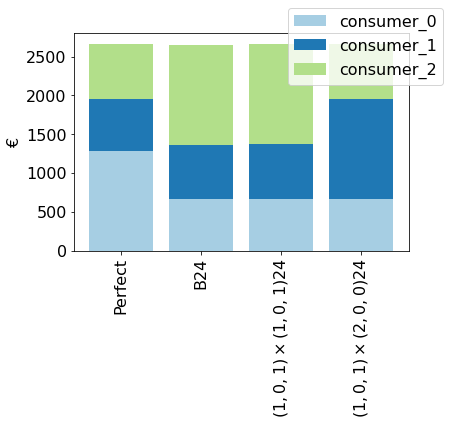

In [36]:
fig, ax = plt.subplots()
legend = create_stacked_barchart(ax, consumer_plot_data_model_comparison, colors=colors)
get_min_max_costs(consumer_plot_data_model_comparison)

fig.legend(legend)
